In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
%matplotlib inline  


/Users/chronowanderer/anaconda3/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TIME_STEPS = 100
HIDDEN_UNITS = 128
INPUT_UNITS = 2
OUTPUT_UNITS = 2
BATCH_SIZE = 64
TRAIN_SIZE = 500
EFFECTIVE_COEFFICIENT = 1.0
EFFECTIVE_LOC = int(TRAIN_SIZE / EFFECTIVE_COEFFICIENT)
EPOCH = 10
look_back = TIME_STEPS


In [3]:
def atan_positive(x, y):
    if (x > 0) & (y > 0):
        theta = math.atan(y / x)
    elif (x == 0) & (y > 0):
        theta = math.pi / 2
    elif (x < 0):
        theta = math.pi + math.atan(y / x)
    elif (x == 0) & (y < 0):
        theta = 3 * math.pi / 2
    elif (x > 0) & (y <= 0):
        theta = 2 * math.pi + math.atan(y / x)
    return theta

def oup2(mu1, mu2, a, sigma, tau, h, lentmax):
    locRT = 0
    theta_T = 999
    x = tau * mu1 * h + sigma * numpy.random.randn(lentmax) * math.sqrt(h)
    y = tau * mu2 * h + sigma * numpy.random.randn(lentmax) * math.sqrt(h)
    a_r = a - math.sqrt(h) * sigma / 2.0
    x_start = 0.0
    y_start = 0.0
    w = [x_start]
    z = [y_start] 
    flag = 0
    for k in numpy.arange(1, lentmax):
        w.append(w[k - 1] + x[k] - tau * w[k - 1] * h)
        z.append(z[k - 1] + y[k] - tau * z[k - 1] * h)
        if (flag == 0) & (w[k] ** 2 + z[k] ** 2 >= a_r ** 2):
            locRT = k
            theta_T = atan_positive(w[k], z[k]) / 2.0
            flag = 1
    return (w, z, theta_T, locRT)


In [4]:
def semicircular_error(r, t):
    e = r - t
    if e >= 90:
        e = e - 180
    elif e < -90:
        e = e + 180
    return e


In [5]:
numSeries = 1 # training & testing & sequently predicting
numPredict = 1 # complete prediction
tmax = 2.0
h = 0.001
lentmax = int(tmax / h)
T = numpy.linspace(0, tmax, lentmax, endpoint = False)
DATA_i = 0
DATA_f = lentmax - 1
norm, a, sigma = [], [], []
Target, Response, Error, RTloc = [], [], [], []
Dat = []

i = 0
while i < (numSeries + numPredict):
    '''
    norm0 = numpy.random.uniform(0.1, 10)
    a0 = numpy.random.uniform(0.1, 10)
    sigma0 = numpy.random.uniform(0.1, 10)
    RESP = numpy.random.randint(0, 180)
    '''
    norm0 = 1.0
    a0 = 1.0
    sigma0 = 1.0
    tau0 = 1.0
    RESP = 60
    if RESP == 0:
        RESP = 180;
    mu1 = norm0 * math.cos(2 * RESP * math.pi / 180)
    mu2 = norm0 * math.sin(2 * RESP * math.pi / 180)
    (L_x, L_y, theta, t_loc) = oup2(mu1, mu2, a0, sigma0, tau0, h, lentmax)
    if t_loc >= EFFECTIVE_LOC:
        norm.append(norm0)
        a.append(a0)
        sigma.append(sigma0)
        Target.append(RESP)
        Response.append(theta / math.pi * 180)
        Error.append(semicircular_error(theta / math.pi * 180, RESP))
        RTloc.append(t_loc)
        temp = []
        for j in numpy.arange(lentmax):
            temp.append([L_x[j], L_y[j]])
        Dat.append(temp)
        i = i + 1

Dat = numpy.array(Dat) # all data
Data = Dat[0 : numSeries, :, :] # training & testing & sequently predicting
Data_p = Dat[numSeries : numSeries + numPredict, :, :] # complete prediction

dataset = []
for i in numpy.arange(numSeries):
    for j in numpy.arange(lentmax):
        dataset.append(Data[i, j])
dataset = numpy.array(dataset)

print dataset.shape


(2000, 2)


In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


In [7]:
TOTAL_TIME = Data.shape[1]

# split into train and test sets
train_size = TRAIN_SIZE
test_size = TOTAL_TIME - train_size + look_back
train, test = [], []
for k in range(numSeries):
    kk = k * TOTAL_TIME
    for t in range(kk, kk+train_size):
        train.append(dataset[t, :])
    for t in range(kk+train_size-look_back, kk+TOTAL_TIME):
        test.append(dataset[t, :])
train = numpy.array(train)
test = numpy.array(test)
        
print train.shape, test.shape

# use this function to prepare the train and test datasets for modeling
trainX, trainY, testX, testY, predictY = [], [], [], [], []
for k in range(numSeries):
    kk = k * train_size
    for i in range(train_size - look_back):
        temp = train[(kk + i) : (kk + i + look_back), :]
        trainX.append(temp)
        trainY.append(train[kk + i + look_back, :])
    kk = k * test_size
    testX.append(test[kk : (kk + look_back), :])
    testY.append(test[kk + look_back, :])
    for i in range(look_back, test_size):
        predictY.append(test[kk + i, :])
trainX = numpy.array(trainX)
trainY = numpy.array(trainY)
testX = numpy.array(testX)
testY = numpy.array(testY)
predictY = numpy.array(predictY)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))

print trainX.shape, trainY.shape
print testX.shape, testY.shape
print predictY.shape


(500, 2) (1600, 2)
(400, 100, 2) (400, 2)
(1, 100, 2) (1, 2)
(1500, 2)


In [8]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(HIDDEN_UNITS, input_shape=(look_back, INPUT_UNITS)))
model.add(Dense(OUTPUT_UNITS))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs = EPOCH, batch_size = BATCH_SIZE, verbose = 2)


Epoch 1/10
 - 1s - loss: 0.3296
Epoch 2/10
 - 1s - loss: 0.0320
Epoch 3/10
 - 1s - loss: 0.0102
Epoch 4/10
 - 1s - loss: 0.0096
Epoch 5/10
 - 1s - loss: 0.0053
Epoch 6/10
 - 1s - loss: 0.0039
Epoch 7/10
 - 1s - loss: 0.0038
Epoch 8/10
 - 1s - loss: 0.0030
Epoch 9/10
 - 1s - loss: 0.0028
Epoch 10/10
 - 1s - loss: 0.0025


In [9]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
predictPredict = []
for i in range(numSeries):
    X_temp = testX[i]
    X_temp = numpy.reshape(X_temp, (1, look_back, OUTPUT_UNITS))
    for t in range(test_size - look_back):
        Y_temp = model.predict(X_temp)
        predictPredict.append(Y_temp[0])
        for l in range(look_back - 1):
            X_temp[0, l] = X_temp[0, l + 1]
        X_temp[0, look_back - 1] = Y_temp[0]
predictPredict = numpy.array(predictPredict)
print predictPredict.shape


(1500, 2)


In [10]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
predictPredict = scaler.inverse_transform(predictPredict)
predictY = scaler.inverse_transform(predictY)

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.4f RMSE' % (testScore))
predictScore = math.sqrt(mean_squared_error(predictY, predictPredict))
print('Predict Score: %.4f RMSE' % (predictScore))


Train Score: 0.0758 RMSE
Test Score: 0.0752 RMSE
Predict Score: 0.5379 RMSE


In [11]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(Data)
trainPredictPlot[:, :, :] = numpy.nan
for s in range(numSeries):
    for t in range(train_size - look_back):
        trainPredictPlot[s, t + look_back, :] = trainPredict[t + s * (TRAIN_SIZE - look_back), :]

# shift complete predictions for plotting
predictPredictPlot = numpy.empty_like(Data)
predictPredictPlot[:, :, :] = numpy.nan
for s in range(numSeries):
    for t in range(test_size - look_back):
        predictPredictPlot[s, t + TRAIN_SIZE, :] = predictPredict[t + s * (test_size - look_back), :]


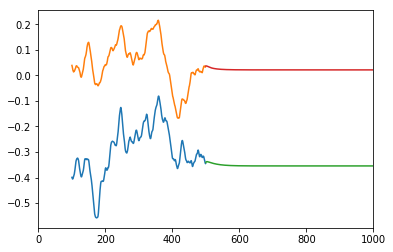

In [13]:
lll = 0
plt.plot(trainPredictPlot[lll])
plt.plot(predictPredictPlot[lll])
plt.xlim(0, 1000)
plt.show()


In [12]:
# Output the estimation score
Observed_theta, Observed_error, Observed_locRT = [], [], []
Estimated_theta, Estimated_error, Estimated_locRT = [], [], []
for s in range(numSeries):
    a_r = a[s] - math.sqrt(h) * sigma[s] / 2.0
    for k in range(lentmax):
        temp = trainPredictPlot[s, k, :]
        if (temp[0] ** 2 + temp[1] ** 2 >= a_r ** 2):
            Observed_locRT.append(RTloc[s])
            Estimated_locRT.append(k)
            Observed_theta.append(Response[s])
            tt = atan_positive(temp[0], temp[1]) / 2.0 / math.pi * 180
            Estimated_theta.append(tt)
            Observed_error.append(Error[s])
            Estimated_error.append(semicircular_error(tt, Target[s]))
            break
        temp = predictPredictPlot[s, k, :]
        if (temp[0] ** 2 + temp[1] ** 2 >= a_r ** 2):
            Observed_locRT.append(RTloc[s])
            Estimated_locRT.append(k)
            Observed_theta.append(Response[s])
            tt = atan_positive(temp[0], temp[1]) / 2.0 / math.pi * 180
            Estimated_theta.append(tt)
            Observed_error.append(Error[s])
            Estimated_error.append(semicircular_error(tt, Target[s]))
            break
print len(Observed_error)

Res0 = [i * math.pi / 180 for i in Observed_error]
Res = [i * math.pi / 180 for i in Estimated_error]
Err = Res
for i in range((len(Observed_error))):
    Err[i] = (semicircular_error(Estimated_error[i], Observed_error[i]) * math.pi / 180) ** 2
ResponsePredictionScore = math.sqrt(sum(Err) / len(Err))
RT0 = [i * h for i in Observed_locRT]
RT = [i * h for i in Estimated_locRT]
RTPredictionScore = math.sqrt(mean_squared_error(RT0, RT))
            
print('Error Estimation Score: %.4f RMSE' % (ResponsePredictionScore))
print('RT Estimation Score: %.4f RMSE' % (RTPredictionScore))


0


ZeroDivisionError: integer division or modulo by zero

In [ ]:
# plot Response Error and Reaction Time
plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.xlim(-90, 90)
plt.ylim(-90, 90)
plt.scatter(Observed_error, Estimated_error, color = 'b')
plt.xlabel("True Error")  
plt.ylabel("Estimated Error")
xx = numpy.linspace(-90, 90, 1000)
yy = xx
plt.plot(xx, yy, linewidth = 2, color = 'lightgrey')
Observed_error = numpy.array(Observed_error)
reg = LinearRegression().fit(Observed_error.reshape(-1, 1), Estimated_error)
print('R^2 score for regression on Error: %.4f' % (reg.score(Observed_error.reshape(-1, 1), Estimated_error)))
print('k = %.4f' % (reg.coef_))
pred = reg.predict(Observed_error.reshape(-1, 1))
plt.plot(Observed_error, pred, linewidth = 2, color = 'k')
plt.show()

plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.xlim(0, tmax)
plt.ylim(0, tmax)
plt.scatter(RT0, RT, color = 'b')
plt.xlabel("True RT")  
plt.ylabel("Estimated RT")
xx = numpy.linspace(EFFECTIVE_LOC * h, tmax, 1000)
yy = xx
plt.plot(xx, yy, linewidth = 2, color = 'lightgrey')
RT0 = numpy.array(RT0)
reg = LinearRegression().fit(RT0.reshape(-1, 1), RT)
print('R^2 score for regression on RT: %.4f' % (reg.score(RT0.reshape(-1, 1), RT)))
print('k = %.4f' % (reg.coef_))
pred = reg.predict(RT0.reshape(-1, 1))
plt.plot(RT0, pred, linewidth = 2, color = 'k')
plt.axvline((TRAIN_SIZE - 1) * h, linestyle="dashed", linewidth = 2, color='g')
plt.axvline(EFFECTIVE_LOC * h, linestyle="dashed", linewidth = 2, color='r')
plt.show()


In [ ]:
dataset_p = []
for i in numpy.arange(numPredict):
    for j in numpy.arange(lentmax):
        dataset_p.append(Data_p[i, j])
dataset_p = numpy.array(dataset_p)
print dataset_p.shape

dataset_p = scaler.fit_transform(dataset_p)
P_predictY = []
for k in range(numPredict):
    kk = k * (TOTAL_TIME - look_back)
    for i in range(look_back, TOTAL_TIME):
        P_predictY.append(dataset_p[kk + i, :])
P_predictY = numpy.array(P_predictY)
print P_predictY.shape

P_predict = []
for i in range(numPredict):
    kk = i * lentmax
    X_temp = dataset_p[kk : (kk + look_back), :]
    X_temp = numpy.reshape(X_temp, (1, look_back, OUTPUT_UNITS))
    for t in range(TOTAL_TIME - look_back):
        Y_temp = model.predict(X_temp)
        P_predict.append(Y_temp[0])
        for l in range(look_back - 1):
            X_temp[0, l] = X_temp[0, l + 1]
        X_temp[0, look_back - 1] = Y_temp
P_predict = numpy.array(P_predict)
print P_predict.shape


In [ ]:
P_predictY = scaler.inverse_transform(P_predictY)
P_predict = scaler.inverse_transform(P_predict)
P_predictScore = math.sqrt(mean_squared_error(P_predictY, P_predict))
print('Fully-Predict Score: %.4f RMSE' % (P_predictScore))


In [ ]:
ppPredictPlot = numpy.empty_like(Data_p)
ppPredictPlot[:, :, :] = numpy.nan
for s in range(numPredict):
    for t in range(TOTAL_TIME - look_back):
        ppPredictPlot[s, t + look_back, :] = P_predict[t + s * (TOTAL_TIME - look_back), :]
        

In [ ]:
# Output the estimation score
Observed_theta, Observed_error, Observed_locRT = [], [], []
Estimated_theta, Estimated_error, Estimated_locRT = [], [], []
for s in range(numSeries,  numSeries + numPredict):
    a_r = a[s] - math.sqrt(h) * sigma[s] / 2.0
    for k in range(lentmax):
        temp = ppPredictPlot[s - numSeries, k, :]
        if (temp[0] ** 2 + temp[1] ** 2 >= a_r ** 2):
            Observed_locRT.append(RTloc[s])
            Estimated_locRT.append(k)
            Observed_theta.append(Response[s])
            tt = atan_positive(temp[0], temp[1]) / 2.0 / math.pi * 180
            Estimated_theta.append(tt)
            Observed_error.append(Error[s])
            Estimated_error.append(semicircular_error(tt, Target[s]))
            break
print len(Observed_error)

Res0 = [i * math.pi / 180 for i in Observed_error]
Res = [i * math.pi / 180 for i in Estimated_error]
Err = Res
for i in range((len(Observed_error))):
    Err[i] = (semicircular_error(Estimated_error[i], Observed_error[i]) * math.pi / 180) ** 2
ResponsePredictionScore = math.sqrt(sum(Err) / len(Err))
RT0 = [i * h for i in Observed_locRT]
RT = [i * h for i in Estimated_locRT]
RTPredictionScore = math.sqrt(mean_squared_error(RT0, RT))
            
print('Error Estimation Score: %.4f RMSE' % (ResponsePredictionScore))
print('RT Estimation Score: %.4f RMSE' % (RTPredictionScore))


In [ ]:
# plot Response Error and Reaction Time
plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.xlim(-90, 90)
plt.ylim(-90, 90)
plt.scatter(Observed_error, Estimated_error, color = 'b')
plt.xlabel("True Error")  
plt.ylabel("Estimated Error")
xx = numpy.linspace(-90, 90, 1000)
yy = xx
plt.plot(xx, yy, linewidth = 2, color = 'lightgrey')
Observed_error = numpy.array(Observed_error)
reg = LinearRegression().fit(Observed_error.reshape(-1, 1), Estimated_error)
print('R^2 score for regression on Error: %.4f' % (reg.score(Observed_error.reshape(-1, 1), Estimated_error)))
print('k = %.4f' % (reg.coef_))
pred = reg.predict(Observed_error.reshape(-1, 1))
plt.plot(Observed_error, pred, linewidth = 2, color = 'k')
plt.show()

plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
plt.xlim(0, tmax)
plt.ylim(0, tmax)
plt.scatter(RT0, RT, color = 'b')
plt.xlabel("True RT")  
plt.ylabel("Estimated RT")
xx = numpy.linspace(EFFECTIVE_LOC * h, tmax, 1000)
yy = xx
plt.plot(xx, yy, linewidth = 2, color = 'lightgrey')
RT0 = numpy.array(RT0)
reg = LinearRegression().fit(RT0.reshape(-1, 1), RT)
print('R^2 score for regression on RT: %.4f' % (reg.score(RT0.reshape(-1, 1), RT)))
print('k = %.4f' % (reg.coef_))
pred = reg.predict(RT0.reshape(-1, 1))
plt.plot(RT0, pred, linewidth = 2, color = 'k')
plt.axvline((TRAIN_SIZE - 1) * h, linestyle="dashed", linewidth = 2, color='g')
plt.axvline(EFFECTIVE_LOC * h, linestyle="dashed", linewidth = 2, color='r')
plt.show()
